In [1]:
import pandas as pd
import rasterio
from pathlib import Path
import geopandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sites = pd.read_csv("NBP1902MC-cores.csv")

In [3]:
dirs = list(Path("daily").glob("images_*"))
df = pd.DataFrame()
for image_dir in dirs:
    for tif_num, file in enumerate(image_dir.glob("*.tif")):
        fn = str(file)
        tif = rasterio.open(fn)
        data = tif.read()[0, :, :]
        gdf = geopandas.geodataframe.GeoDataFrame(sites)
        gdf["geometry"] = geopandas.points_from_xy(sites.X, sites.Y, crs="EPSG:4326")
        gdf = gdf.to_crs(tif.crs)
        row_dict = {}
        row_dict["date"] = fn.split("/")[-1].split(".")[0]
        with rasterio.open(fn) as src:
            for i, df_row in gdf.iterrows():
                geom = df_row["geometry"]
                row, col = rasterio.transform.rowcol(src.transform, geom.x, geom.y)
                pixel_value =  data[row, col]
                row_dict[df_row.Name] = pixel_value
        df = pd.concat((df, pd.DataFrame(row_dict,index = [tif_num], )))
df = df.sort_values(by="date")
df = df.set_index("date")

In [4]:
# https://seaice.uni-bremen.de/data-archive/. Ice concentrations are scaled between 0 and 100, land and missing values are set to 120 (older files: SIC: 0-200, land/NaN: 255).  
df[df==255] = np.nan
df_percent_cover = df / 2

In [5]:
threshold = 50
df_classify = df_percent_cover.copy()
df_classify[df_percent_cover>threshold] = 0
df_classify[df_percent_cover<=threshold] = 1

In [6]:
df_classify

,MC 06,MC 09,MC 16,MC 22,MC 26,BC 28
date,,,,,,
2014-12-01,0.0,0.0,0.0,0.0,1.0,1.0
2014-12-02,0.0,0.0,0.0,0.0,1.0,1.0
2014-12-03,0.0,0.0,0.0,0.0,1.0,0.0
2014-12-04,0.0,0.0,0.0,0.0,1.0,1.0
2014-12-05,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...
2019-02-27,0.0,1.0,1.0,0.0,1.0,1.0
2019-02-28,0.0,1.0,1.0,0.0,1.0,1.0
2019-03-01,0.0,1.0,1.0,0.0,0.0,1.0


In [7]:
df_percent_cover

,MC 06,MC 09,MC 16,MC 22,MC 26,BC 28
date,,,,,,
2014-12-01,85.5,96.0,91.5,98.5,0.0,11.5
2014-12-02,90.5,95.5,92.5,96.5,0.0,1.5
2014-12-03,94.0,97.5,95.5,97.5,0.0,52.0
2014-12-04,93.5,99.5,94.0,98.0,0.0,35.5
2014-12-05,92.5,96.0,96.0,99.0,0.0,16.5
...,...,...,...,...,...,...
2019-02-27,58.0,6.5,2.5,85.0,26.0,0.0
2019-02-28,50.5,0.0,46.0,100.0,24.5,0.0
2019-03-01,50.5,44.5,35.0,97.5,51.5,0.0


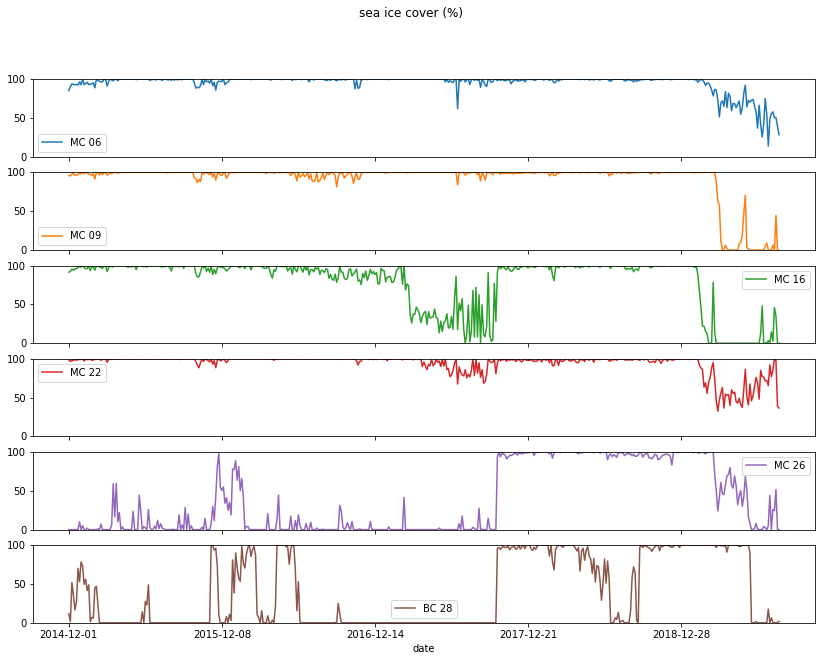

In [8]:
fig = df_percent_cover.plot(subplots=True, figsize=(14, 10), ylim=(0, 100),title="sea ice cover (%)");
plt.savefig("sea_ice_cover.png")

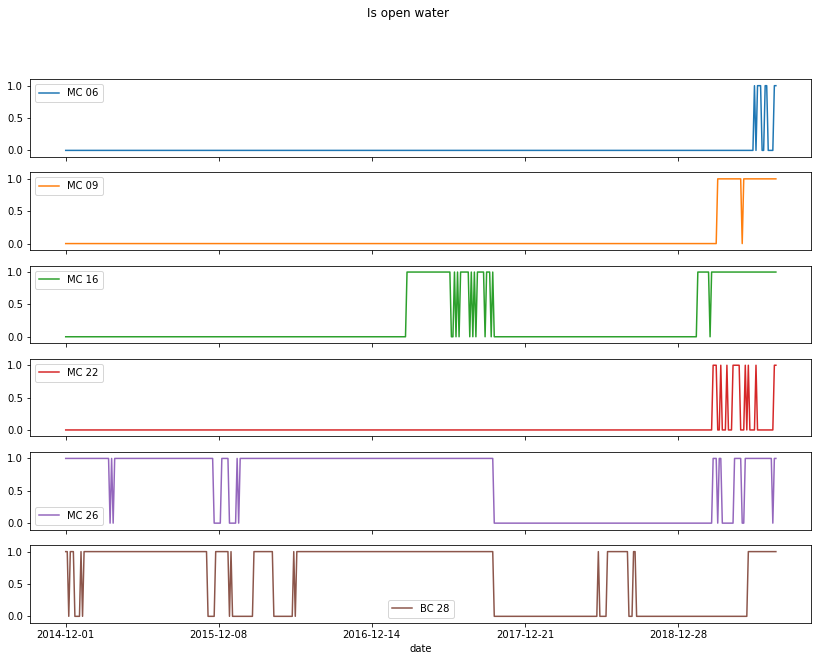

In [9]:
df_classify.plot(subplots=True, figsize=(14, 10), ylim=(-0.1, 1.1),title="Is open water");
plt.savefig("figures/open_water.png")

In [10]:
df_percent_cover.mean()

MC 06    95.172043
MC 09    90.849462
MC 16    78.236559
MC 22    93.773118
MC 26    37.039785
BC 28    39.155914
dtype: float64

In [11]:
df_classify.mean()

MC 06    0.017204
MC 09    0.081720
MC 16    0.212903
MC 22    0.032258
MC 26    0.638710
BC 28    0.593548
dtype: float64